## Hemoglobin and Transfusion Extraction for RDD Projects
## C.V. Cosgriff, MD, MPH
### MIT Critical Data

## 0 - Envrionement Setup

In [1]:
import numpy as np
import pandas as pd
import qgrid as qg
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dbname = 'eicu'
schema_name = 'eicu_crd'
query_schema = 'SET search_path TO ' + schema_name + ';'
con = psycopg2.connect(dbname=dbname)

## 1 - Extract Hemoglobin and Transfusion Events

In [2]:
hb_query = query_schema + '''
SELECT l.patientunitstayid, l.labresult AS hb, l.labresultoffset
FROM lab l
WHERE l.labname = 'Hgb'
ORDER BY l.patientunitstayid, l.labresultoffset ASC;
'''

hb_df = pd.read_sql_query(hb_query, con)
print(hb_df.shape)
hb_df.head()

(1298708, 3)


,patientunitstayid,hb,labresultoffset
0,141168,13.0,516
1,141168,13.3,1133
2,141168,11.4,2026
3,141178,15.5,-280
4,141179,12.5,1487


Next, we grab all transfusions of pRBCs.

In [3]:
prbc_query = query_schema + '''
SELECT t.patientunitstayid, t.treatmentoffset
FROM treatment t
WHERE LOWER(treatmentstring) LIKE '%prbc%'
ORDER BY t.patientunitstayid, t.treatmentoffset ASC;
'''

prbc_df = pd.read_sql_query(prbc_query, con)
print(prbc_df.shape)
prbc_df.head()

(22166, 2)


,patientunitstayid,treatmentoffset
0,242816,520
1,242816,522
2,242816,523
3,242816,654
4,242816,1223


How we combine these data is one of the fundamental challenges of this work. 

## 2 - Defining the Exposure

In clinical practice hemoglobin values are checked in both a routine fashion, and when there is concern for an active bleed or other process that results in red cell consumption such as a hemolysis. This work will attempt to examine the often used threshold of $7g/dl$ that has become standard process since the TRICC trial; there are various populations that this cutoff doesn't apply to. Nevertheless, to address this we need an appropriate definition of _transfused_ that reflects if a transfusion decision occurred as a result of an index hemoglobin level.

For example if a hemoglobin of 7.4 is measured in the morning, and the plan is to repeat measurement at 3PM and transfuse if the value has dropped below 7 then we would expect to find a second hemoglobin level in the data. If that subsequent value is below 7 and there is a temporally associated transfusion then the transfusion goal of 7 was respected. The challenge therefore when extracting the data is which hemoglobin to extract for each patient. If we used the first, so in this example 7.4, and then detect a transfusion on the same day in the data, we capture the wrong scenario. If we use the minimum, say 6.7 in this scenario, we may capture this episode correctly, but consider the following: what if the transfusion occurred before the lowest and the threshold of 7 was therefore not followed.

At the same time we can't look back simply at the preceeding hemoglobin level for each transfusion because we would then condition on recieving treatment and would not be able to capture those who were never transfused correctly.

Before continuing lets look at some example data.

In [4]:
test_hb = hb_df.loc[hb_df.patientunitstayid == 242816, :]
test_tf = prbc_df.loc[prbc_df.patientunitstayid == 242816, :]

In [5]:
test_hb

,patientunitstayid,hb,labresultoffset
83072,242816,5.3,-91
83073,242816,6.0,344
83074,242816,6.3,629
83075,242816,7.0,945
83076,242816,7.2,1230
83077,242816,7.0,1704
83078,242816,7.2,2344
83079,242816,8.3,3113
83080,242816,8.2,3699
83081,242816,8.0,5204


In [6]:
test_tf

,patientunitstayid,treatmentoffset
0,242816,520
1,242816,522
2,242816,523
3,242816,654
4,242816,1223
5,242816,1226
6,242816,1599


This patient was transfused multiple times. 

At 91 minutes before ICU admission they had a hemoglobin level of 5.3, and we have no data to suggest they were transfused although it may be that treatments before the ICU are not captured.

At 344 minutes from ICU admission the level is 6. The next recorded level is 6.3 at 629 minutes from ICU admission. In between these two time points are three orders corresponding to transfusion. __The patient appears to not be responding to transfusion.__

Another transfusion is noted at 654 minutes from ICU admission, soon after the prior hemoglobin of 6.3 at 629 minutes from admission. The next recorded hemoglobin level is 7 at 945 minutes from ICU admission.

Between time 945 and 1230 another two transfusion events occur at 1223 and 1226; this is odd because they are much later than the 945 CBC and preceeds the next CBC only by 7 minutes. One might surmise that the timestamps are a bit off and that this 1230 CBC is a post-transfusion CBC, or that a transfusion was ordered to be given conditionally on the level of the CBC.

At 1599 we see one more transfusion, far after the 1230 CBC, and the next Hb we get is at 2344 and is a level of 7.2. However, looking forward we see that the next Hb level recorded goes up to 8.3 at 3113 minutes from admission and then stays stable.

The bigger question may be: __were hemoglobin levels driving any of the decision making at all?__ Lets look at why this patient was admitted in the first place.

In [8]:
query =  query_schema + '''
SELECT * FROM patient WHERE patientunitstayid = 242816;
'''

pd.read_sql_query(query, con).T

,0
patientunitstayid,242816
patienthealthsystemstayid,207921
gender,Male
age,66
ethnicity,Caucasian
hospitalid,92
wardid,143
apacheadmissiondx,"Bleeding, GI-location unknown"
admissionheight,185.4
hospitaladmittime24,21:05:00


This patient was admitted for an acute GI bleed, and was likely transfused as he was actively hemorrhaging. This would explain the timestamp discrepancy.

We will likely have to exclude patients actively hemorrhaging. Lets take a step back and see which patients got transfused.

In [11]:
query = query_schema + '''
WITH prbc AS (
    SELECT t.patientunitstayid
    FROM treatment t
    WHERE LOWER(treatmentstring) LIKE '%prbc%'
)
SELECT * FROM patient p
INNER JOIN prbc 
    ON p.patientunitstayid = prbc.patientunitstayid;
'''

transfused_patients = pd.read_sql_query(query, con)
print(transfused_patients.shape)
display(transfused_patients.head())

(22166, 30)


,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,patientunitstayid
0,242816,207921,Male,66,Caucasian,92,143,"Bleeding, GI-location unknown",185.4,21:05:00,...,1,admit,95.3,97.7,16:44:00,2603,Floor,Alive,003-2921,242816
1,242816,207921,Male,66,Caucasian,92,143,"Bleeding, GI-location unknown",185.4,21:05:00,...,1,admit,95.3,97.7,16:44:00,2603,Floor,Alive,003-2921,242816
2,242816,207921,Male,66,Caucasian,92,143,"Bleeding, GI-location unknown",185.4,21:05:00,...,1,admit,95.3,97.7,16:44:00,2603,Floor,Alive,003-2921,242816
3,242816,207921,Male,66,Caucasian,92,143,"Bleeding, GI-location unknown",185.4,21:05:00,...,1,admit,95.3,97.7,16:44:00,2603,Floor,Alive,003-2921,242816
4,242816,207921,Male,66,Caucasian,92,143,"Bleeding, GI-location unknown",185.4,21:05:00,...,1,admit,95.3,97.7,16:44:00,2603,Floor,Alive,003-2921,242816


We can then ask how many unique diagnoses there are.

In [45]:
admit_dx = pd.Categorical(transfused_patients.apacheadmissiondx)
unique_dx = admit_dx.value_counts()
unique_dx

                                                                                   166
ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema          116
Abdomen only trauma                                                                 85
Abdomen/extremity trauma                                                            38
Abdomen/face trauma                                                                  1
                                                                                  ... 
Vascular medical, other                                                             32
Vascular surgery, other                                                             41
Vena cava clipping                                                                   2
Weaning from mechanical ventilation (transfer from other unit or hospital only)      8
Whipple-surgery for pancreatic cancer                                               47
Length: 296, dtype: int64

There are 296, lets try and limit ourselves to common for now.

In [46]:
unique_dx[unique_dx > 100]

                                                                                                                                 166
ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema                                                        116
Abdomen/multiple trauma                                                                                                          125
Acid-base/electrolyte disturbance                                                                                                101
Anemia                                                                                                                           565
Aortic valve replacement (isolated)                                                                                              174
Arrest, respiratory (without cardiac arrest)                                                                                     253
Bleeding, GI from esophageal varices/portal hypertension             

We can plot this data.

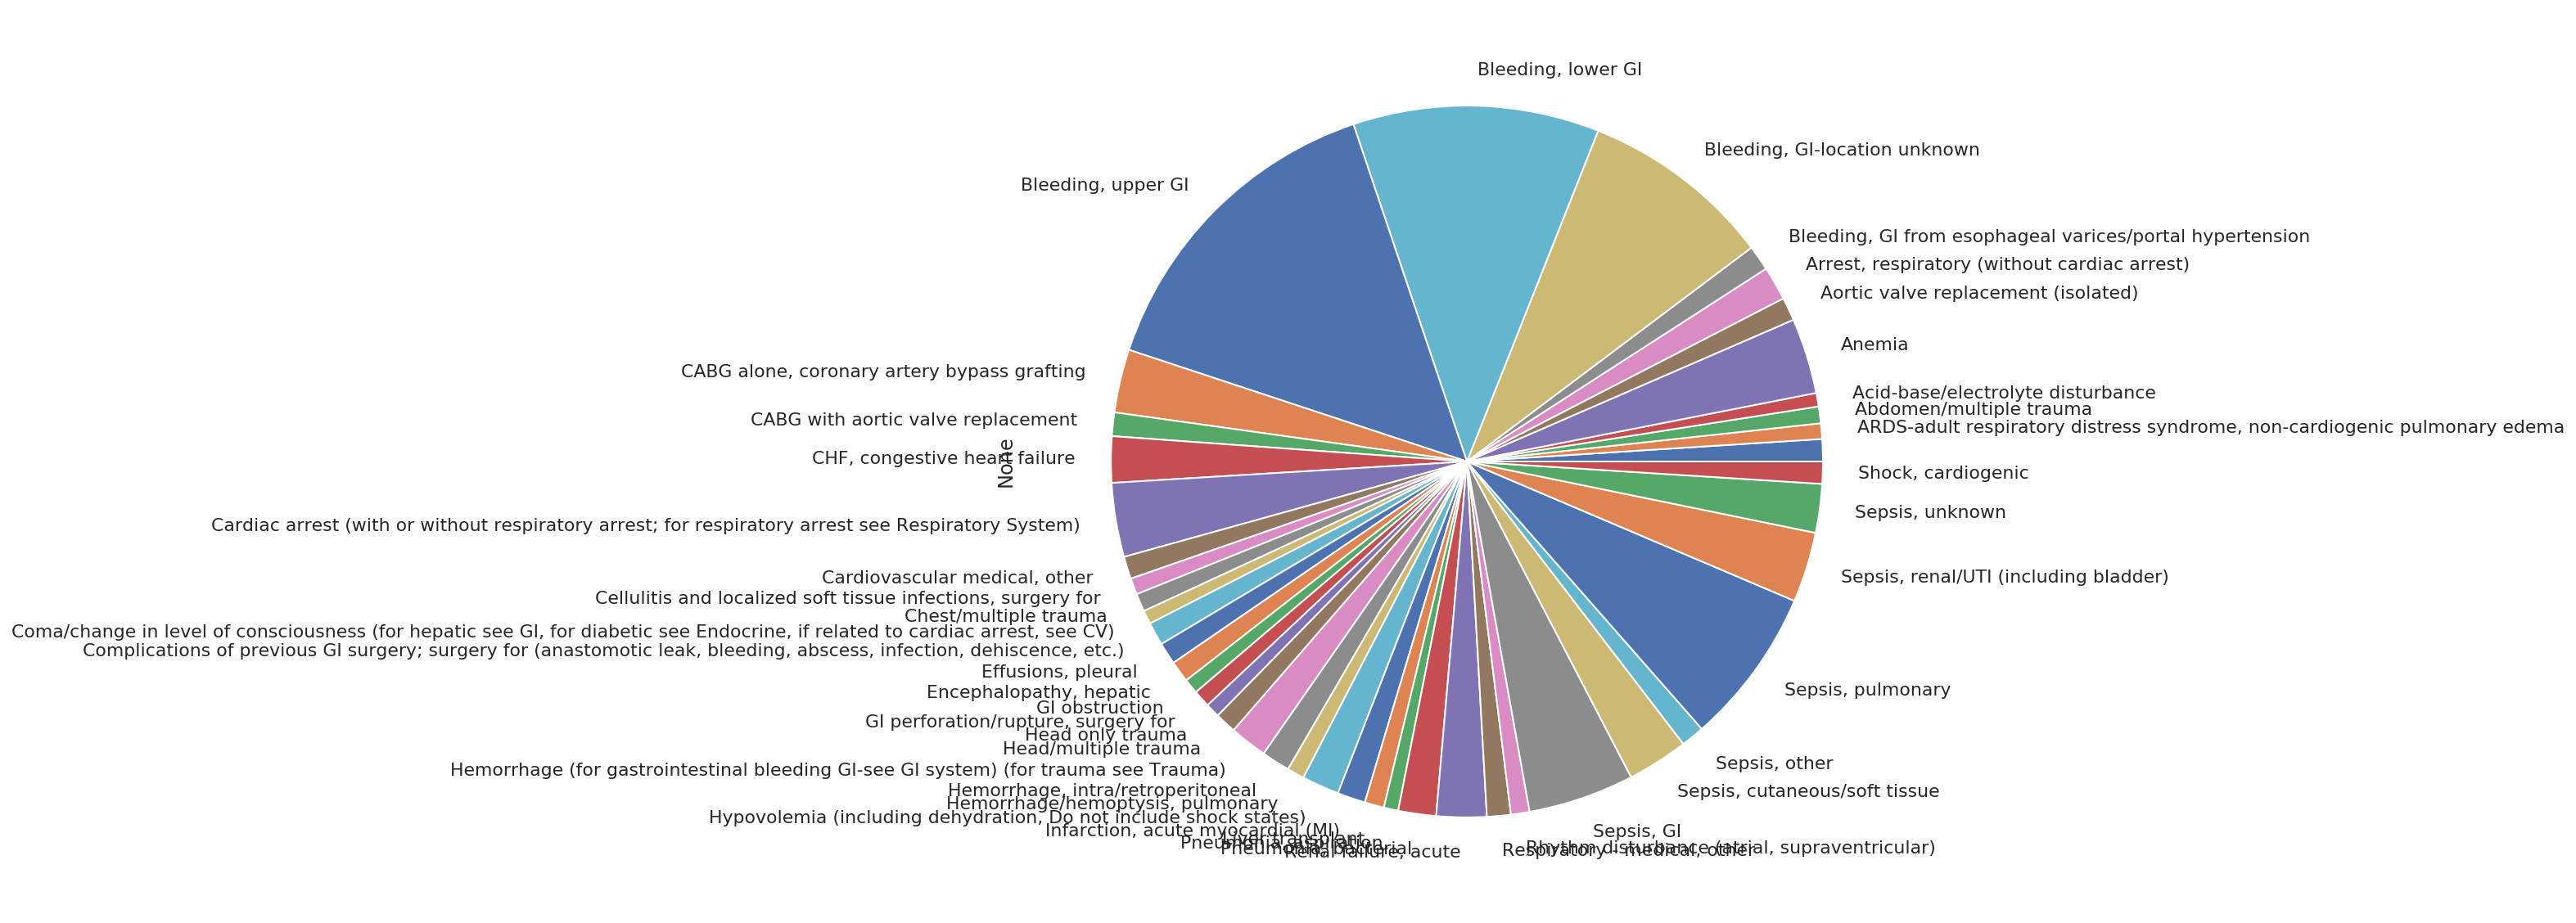

In [47]:
unique_dx[unique_dx > 100].plot(kind='pie', figsize=(10,10))

A large number of patients who recieve transfusion come in for acute GI bleed. I expect many of these patients will have a similar pattern of transfusion to the above patient example. Lets try a sepsis patient instead.

In [55]:
transfused_patients.loc[transfused_patients.apacheadmissiondx == 'Sepsis, pulmonary'].head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,patientunitstayid
30,245240,210093,Female,39,Native American,79,133,"Sepsis, pulmonary",170.2,00:34:00,...,1,admit,65.8,80.9,21:22:00,1231,Death,Expired,003-19541,245240
31,245240,210093,Female,39,Native American,79,133,"Sepsis, pulmonary",170.2,00:34:00,...,1,admit,65.8,80.9,21:22:00,1231,Death,Expired,003-19541,245240
36,246013,210765,Female,66,Caucasian,92,143,"Sepsis, pulmonary",165.1,17:47:00,...,1,admit,88.5,88.5,16:35:00,2727,Floor,Alive,003-7927,246013
37,246013,210765,Female,66,Caucasian,92,143,"Sepsis, pulmonary",165.1,17:47:00,...,1,admit,88.5,88.5,16:35:00,2727,Floor,Alive,003-7927,246013
79,253602,217601,Male,75,,102,125,"Sepsis, pulmonary",165.1,04:57:00,...,1,admit,56.6,66.0,05:47:00,13441,Other Hospital,Alive,003-22478,253602


In [58]:
test_hb = hb_df.loc[hb_df.patientunitstayid == 245240, :]
test_tf = prbc_df.loc[prbc_df.patientunitstayid == 245240, :]

In [59]:
test_hb

,patientunitstayid,hb,labresultoffset
83584,245240,15.0,-171
83585,245240,13.3,-119
83586,245240,7.7,422
83587,245240,8.5,460
83588,245240,8.4,830
83589,245240,8.2,881
83590,245240,8.0,921
83591,245240,7.5,957
83592,245240,7.1,1151


In [60]:
test_tf

,patientunitstayid,treatmentoffset
30,245240,658
31,245240,1080


This data is again very confusing. Before admission to the ICU this patient had normal hemoglobin levels. The first CBC in the ICU occurs ~7 hours into the stay and the patient has a hemoglobin of 7.7. A repeat is 8.5, and then there is a transfusion before the next recorded hemoglobin which returns as 8.4. The hemoglobin down trends from 8.4 to 7.5 with repeated sampling and then there is another transfusion before the final recorded value of 7.1. In both cases transfusion is done above threshold and a decrease in hemoglobin level follows.

For a last exploratory example, lets look at anemia.

In [62]:
transfused_patients.loc[transfused_patients.apacheadmissiondx == 'Anemia'].head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,patientunitstayid
88,254027,217989,Female,> 89,Caucasian,95,126,Anemia,157.5,19:10:00,...,1,admit,84.3,92.9,17:28:00,5256,Floor,Alive,003-35097,254027
89,254027,217989,Female,> 89,Caucasian,95,126,Anemia,157.5,19:10:00,...,1,admit,84.3,92.9,17:28:00,5256,Floor,Alive,003-35097,254027
90,254027,217989,Female,> 89,Caucasian,95,126,Anemia,157.5,19:10:00,...,1,admit,84.3,92.9,17:28:00,5256,Floor,Alive,003-35097,254027
91,254027,217989,Female,> 89,Caucasian,95,126,Anemia,157.5,19:10:00,...,1,admit,84.3,92.9,17:28:00,5256,Floor,Alive,003-35097,254027
110,255486,219283,Male,54,Native American,79,133,Anemia,180.3,03:00:00,...,1,admit,73.6,73.3,03:03:00,2883,Floor,Alive,003-35277,255486


In [63]:
test_hb = hb_df.loc[hb_df.patientunitstayid == 254027, :]
test_tf = prbc_df.loc[prbc_df.patientunitstayid == 254027, :]

In [64]:
test_hb

,patientunitstayid,hb,labresultoffset
85822,254027,11.5,-3161
85823,254027,9.9,-1727
85824,254027,10.1,-824
85825,254027,8.6,-247
85826,254027,11.3,242
85827,254027,10.6,545
85828,254027,9.7,1086
85829,254027,9.1,1448
85830,254027,11.1,1987
85831,254027,9.4,3417


In [65]:
test_tf

,patientunitstayid,treatmentoffset
88,254027,283
89,254027,577
90,254027,1452
91,254027,3380


This patient's admission diagnosis is _anemia_ and her initial hemoglobin ranges from 11.5 to 8.6 ahead of ICU entry. Her first Hb level in the ICU is 11.3. Between that level and her next level of 10.6 she is transfused. Again, this doesn't really make sense.

The most likely clinical trajectory is that she had a Hb level of 8.6 and was transfused ahead of ICU tranfer.

Similalry at time 545 her hemoglobin 10.6 and at time 1086 its 9.7. However, there is a transfusion at time 577.